In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from time import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [64]:
df = pd.read_csv('housing.csv')

In [65]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [66]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [68]:
df.shape

(20640, 10)

In [69]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [70]:
missing_values = df.isnull().sum().sort_values(ascending = False)
missing_values = pd.DataFrame(df.isnull().sum().sort_values(ascending = False), columns = ['Missing Values'])
missing_values['Percentage'] = missing_values['Missing Values'].apply(lambda x : '{:.2f}'.format(float(x)/df.shape[0] * 100))
missing_values = missing_values[missing_values['Missing Values'] > 0]
missing_values

,Missing Values,Percentage
total_bedrooms,207,1.00


In [71]:
df.dropna(inplace = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


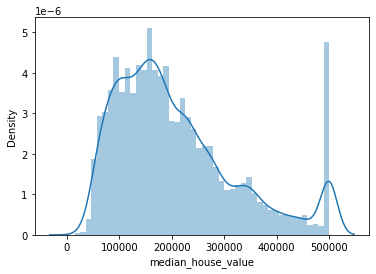

In [72]:
sns.distplot(df['median_house_value'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


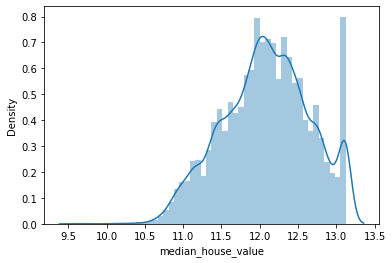

In [73]:
sns.distplot(np.log(df['median_house_value']))

In [74]:
df['log_price'] = np.log(df['median_house_value'])
df.drop(['median_house_value'], axis = 1, inplace = True)

In [75]:
df.skew().sort_values(ascending = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


population            4.960017
total_rooms           4.158816
total_bedrooms        3.459546
households            3.413850
median_income         1.644557
latitude              0.464934
housing_median_age    0.061605
log_price            -0.172580
longitude            -0.296141
dtype: float64

In [76]:
y = df['log_price']
df_temp = df.select_dtypes(include = ['float64'])
X = df_temp.drop(['log_price'], axis = 1)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=0)

In [92]:
regressors = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    RandomForestRegressor(),
    ExtraTreesRegressor(),
    GradientBoostingRegressor()
]

In [93]:
for model in regressors:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

LinearRegression()
	Training time: 0.010s
	Prediction time: 0.002s
	Explained variance: 0.6496019682736858
	Mean absolute error: 0.25607095476650477
	R2 score: 0.649547056369377

Ridge()
	Training time: 0.006s
	Prediction time: 0.003s
	Explained variance: 0.64960261002533
	Mean absolute error: 0.2560721406280109
	R2 score: 0.6495476915085683

Lasso()
	Training time: 0.028s
	Prediction time: 0.002s
	Explained variance: 0.1182815707420688
	Mean absolute error: 0.4329159453017957
	R2 score: 0.11812828769594785

RandomForestRegressor()
	Training time: 9.900s
	Prediction time: 0.173s
	Explained variance: 0.8316708571028313
	Mean absolute error: 0.16111729705447203
	R2 score: 0.8316465294607385

ExtraTreesRegressor()
	Training time: 3.798s
	Prediction time: 0.208s
	Explained variance: 0.8237187660223905
	Mean absolute error: 0.16949597414747475
	R2 score: 0.8236677677939157

GradientBoostingRegressor()
	Training time: 3.185s
	Prediction time: 0.011s
	Explained variance: 0.7871899120432666
	M

In [94]:
param_grid = { 
        "n_estimators"      : [10,20,30],
        "max_features"      : ["auto", "sqrt", "log2"],
        "min_samples_split" : [2,4,8],
        "bootstrap": [True, False],
        }

In [98]:
grid = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv = 5, n_jobs = -1)
grid.fit(X_train, y_train)
print('Best score: ', grid.best_score_)
print('Best parameters: ', grid.best_params_)
print('Best Estimator: ', grid.best_estimator_)

Best score:  0.8278140585178961
Best parameters:  {'bootstrap': True, 'max_features': 'auto', 'min_samples_split': 4, 'n_estimators': 30}
Best Estimator:  RandomForestRegressor(min_samples_split=4, n_estimators=30)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


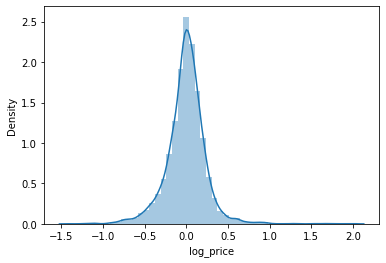

In [99]:
forest = RandomForestRegressor(bootstrap=True, max_features= 'auto', min_samples_split = 4, n_estimators = 30)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
sns.distplot(y_pred - y_test)

In [101]:
df_1 = pd.DataFrame(grid.cv_results_).set_index('rank_test_score').sort_index()
df_1.shape

(54, 16)

In [102]:
df_1.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score
rank_test_score,,,,,,,,,,,,,,,,
1,3.196598,0.020122,0.035805,0.001685,True,auto,4,30,"{'bootstrap': True, 'max_features': 'auto', 'm...",0.844172,0.822362,0.835902,0.816386,0.820248,0.827814,0.010494
2,3.931350,0.500946,0.053169,0.020111,True,auto,2,30,"{'bootstrap': True, 'max_features': 'auto', 'm...",0.846383,0.819455,0.834381,0.816385,0.821846,0.827690,0.011171
3,3.399848,0.542462,0.050045,0.034546,True,auto,8,30,"{'bootstrap': True, 'max_features': 'auto', 'm...",0.843935,0.820198,0.831017,0.812484,0.823247,0.826176,0.010683
4,2.129386,0.017623,0.024969,0.000530,True,auto,4,20,"{'bootstrap': True, 'max_features': 'auto', 'm...",0.843601,0.821721,0.831772,0.810869,0.819211,0.825435,0.011268
5,2.294742,0.015073,0.029655,0.000288,True,auto,2,20,"{'bootstrap': True, 'max_features': 'auto', 'm...",0.842416,0.813895,0.831812,0.811084,0.821967,0.824235,0.011602
